https://medium.com/swlh/music-genre-classification-using-transfer-learning-pytorch-ea1c23e36eb8
여기 참고

CNN을 이용해서 음악 분류하는 모델 개발

음악 -> 사진 -> cnn -> classify

In [ ]:
! pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
 !kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                       Diabetes Dataset                                      9KB  2022-10-06 08:55:25          17353        503  1.0              
akshaydattatraykhare/data-for-admission-in-the-university   Data for Admission in the University                  4KB  2022-10-27 11:05:45           4707        113  1.0              
thedevastator/jobs-dataset-from-glassdoor                   Salary Prediction                                     3MB  2022-11-16 13:52:31           1182         37  1.0              
meirnizri/covid19-dataset                                   COVID-19 Dataset    

In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:08<00:00, 162MB/s]
100% 1.21G/1.21G [00:08<00:00, 148MB/s]


In [ ]:
!unzip gtzan-dataset-music-genre-classification.zip

jazz 54 수정 필요

In [ ]:
ls

Data/  genres/  gtzan-dataset-music-genre-classification.zip  sample_data/


In [ ]:
import torch
import torchvision
import torchaudio
import random
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from tqdm.autonotebook import tqdm
import IPython.display as ipd
from torchvision.transforms import ToTensor,transforms

set DataPath

In [ ]:
data_path = '/content/genres'
img_path = 'img_data'

In [26]:
!rm -rf /content/genres/jazz/.ipynb_checkpoints

Now we will convert the music files i.e .wav files to image format using the Librosa library. A detailed explanation can be found [here]('https://www.kaggle.com/msripooja/steps-to-convert-audio-clip-to-spectrogram').


In [27]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in tqdm(genres):
    pathlib.Path(f'{img_path}/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'{data_path}/{g}'):
        songname = f'{data_path}/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'{img_path}/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 576x576 with 0 Axes>

Visualize

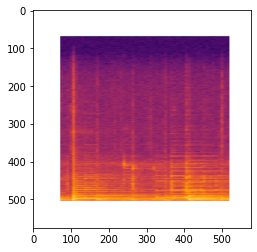

shape of image is: (576, 576, 4)


In [28]:
import matplotlib.image as mpimg

img=mpimg.imread(img_path+'/blues/blues00093.png')
imgplot = plt.imshow(img)
plt.show()
print('shape of image is:',img.shape)

Now we will create a custom dataset:

In [29]:
batch_size = 8
image_size = 224

def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()

train_transforms = transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
mean,std = normalization_parameter(train_loader)

  0%|          | 0/125 [00:00<?, ?it/s]

In [30]:
mean,std

(array([0.89165914, 0.61337245, 0.54622465], dtype=float32),
 array([0.14195646, 0.33950707, 0.38715097], dtype=float32))

In [31]:
train_transforms = transforms.Compose([transforms.Resize((image_size,image_size)),
                                        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size=299),  # Image net standards
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([transforms.Resize((299,299)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)
])
# test_transforms = transforms.Compose([transforms.Resize((image_size,image_size)),
#                                         transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
#                                         transforms.RandomHorizontalFlip(),
#                                         transforms.CenterCrop(size=299),  # Image net standards
#                                         transforms.ToTensor(),
#                                         transforms.Normalize(mean,std)])

In [32]:
#data loader
dataset = torchvision.datasets.ImageFolder(root = img_path, transform =train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = img_path, transform = test_transforms)

In [33]:
#encoder and decoder to convert classes into integer
def encoder(data):
    #label of classes
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder

def decoder(data):
    #label of classes
    classes = data.classes
    
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [34]:
#plotting rondom images from dataset
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
#         print(type(image))
        label = int(label)
        encoders = encoder(data)
        l = encoders[label]
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

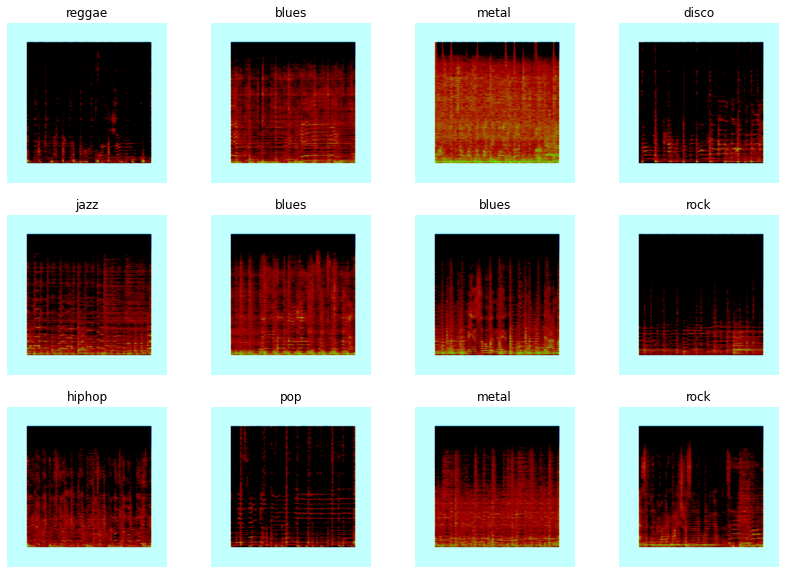

In [35]:
class_plot(test_dataset)

Split 10% for val, 90% for train

In [36]:
torch.manual_seed(43)
val_size = int(len(dataset)*0.2)
train_size = len(dataset) - val_size

from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size,val_size])
len(train_ds), len(val_ds)

(800, 200)

In [37]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

Preview train dataloader

images.shape: torch.Size([8, 3, 299, 299])


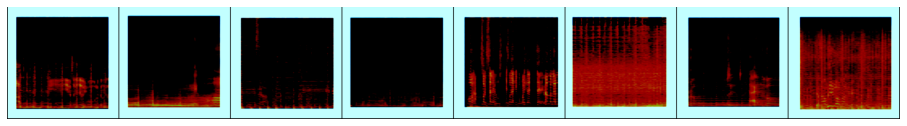

In [38]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [39]:
def accuracy(outputs, labels):
    _,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [63]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.cross_entropy(out, targets)
        return loss
    
    def validation_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.cross_entropy(out, targets)
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epochs_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

Model로는 작은 Resnet34 사용

In [64]:
import torchvision.models as models
from collections import OrderedDict

class Net(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)

        # Replace last layer
        num_ftrs = self.network.fc.in_features
        out_features = 30
        self.network.fc = torch.nn.Sequential(OrderedDict([
            ('ff', nn.Linear(num_ftrs, out_features)),
            ('class', nn.Linear(out_features, 10)),
        ]))
    
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
        
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad = True

In [65]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [66]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, test_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    test_history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        result = evaluate(model, val_loader)
        # test_result = evaluate(model, test_loader)
        result['lrs'] = lrs
        model.epochs_end(epoch, result)
        history.append(result)
        # test_history.append(test_result)
    return {
        'val': history,
        'test': test_history
    }

In [67]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [68]:
torch.cuda.is_available()

True

In [69]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [70]:
device = get_default_device()
device

device(type='cuda')

In [71]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [72]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [90]:
model = Net()

In [91]:
model = model.to(device)

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
history = [evaluate(model, val_loader)]
test_history = [evaluate(model, test_loader)]
result = []

In [93]:
[{'val_loss': v['val_loss'], 'val_score': v['val_score']} for v in history]

[{'val_loss': 2.3683300018310547, 'val_score': 0.07211538404226303}]

In [94]:
[{'val_loss': v['val_loss'], 'val_score': v['val_score']} for v in test_history]

[{'val_loss': 2.37250018119812, 'val_score': 0.1001984104514122}]

In [95]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [96]:
model.freeze()

In [97]:
%%time
result = fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, test_loader,
                         weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.9638, val_score: 0.3125


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.8090, val_score: 0.3413


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.7253, val_score: 0.3654


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.4504, val_score: 0.5192


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.3459, val_score: 0.6010
CPU times: user 22.9 s, sys: 3.7 s, total: 26.6 s
Wall time: 29.4 s


In [98]:
history.extend(result['val'])
test_history.extend(result['test'])

In [99]:
model.unfreeze()

In [100]:
%%time
result = fit_one_cycle(60, max_lr, model, train_loader, val_loader, test_loader,
                         weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0], val_loss: 1.2956, val_score: 0.5625


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.2210, val_score: 0.5673


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.2955, val_score: 0.5481


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.2088, val_score: 0.5673


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.2061, val_score: 0.5673


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.2680, val_score: 0.5817


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.4598, val_score: 0.5481


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.4171, val_score: 0.5288


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.2635, val_score: 0.5096


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.3169, val_score: 0.5144


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.3727, val_score: 0.5192


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.2059, val_score: 0.5577


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.4750, val_score: 0.5000


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.2917, val_score: 0.5673


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.5488, val_score: 0.5144


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.3804, val_score: 0.5144


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.4099, val_score: 0.5865


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.2829, val_score: 0.5144


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.2442, val_score: 0.5625


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.1623, val_score: 0.6250


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20], val_loss: 1.1511, val_score: 0.5769


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [21], val_loss: 1.2907, val_score: 0.5192


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [22], val_loss: 1.1346, val_score: 0.6346


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [23], val_loss: 1.1377, val_score: 0.5913


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [24], val_loss: 1.0912, val_score: 0.6298


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [25], val_loss: 1.2963, val_score: 0.6202


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [26], val_loss: 1.1619, val_score: 0.6298


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [27], val_loss: 1.1482, val_score: 0.6298


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [28], val_loss: 1.1424, val_score: 0.6683


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [29], val_loss: 0.9659, val_score: 0.6827


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [30], val_loss: 1.1399, val_score: 0.6683


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [31], val_loss: 1.1874, val_score: 0.6154


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [32], val_loss: 1.2937, val_score: 0.6202


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.3003, val_score: 0.5769


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [34], val_loss: 1.0718, val_score: 0.7115


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [35], val_loss: 1.1947, val_score: 0.6394


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [36], val_loss: 0.9656, val_score: 0.7067


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [37], val_loss: 1.1223, val_score: 0.6923


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [38], val_loss: 1.1119, val_score: 0.6971


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [39], val_loss: 1.1240, val_score: 0.6779


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [40], val_loss: 1.0490, val_score: 0.6827


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [41], val_loss: 1.1682, val_score: 0.7019


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [42], val_loss: 1.1391, val_score: 0.7115


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [43], val_loss: 1.1512, val_score: 0.6875


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [44], val_loss: 0.9826, val_score: 0.7163


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [45], val_loss: 1.0645, val_score: 0.7163


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [46], val_loss: 1.1327, val_score: 0.7260


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [47], val_loss: 1.1300, val_score: 0.7548


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [48], val_loss: 1.0475, val_score: 0.7115


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [49], val_loss: 0.9761, val_score: 0.7163


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [50], val_loss: 1.0611, val_score: 0.6971


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [51], val_loss: 1.0111, val_score: 0.7404


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [52], val_loss: 1.0928, val_score: 0.7115


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [53], val_loss: 1.0180, val_score: 0.7452


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [54], val_loss: 1.0536, val_score: 0.7212


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [55], val_loss: 1.0933, val_score: 0.7260


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [56], val_loss: 1.0803, val_score: 0.7308


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [57], val_loss: 1.0196, val_score: 0.7308


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [58], val_loss: 1.0402, val_score: 0.7260


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [59], val_loss: 0.9494, val_score: 0.7548
CPU times: user 4min 34s, sys: 48.6 s, total: 5min 23s
Wall time: 5min 52s


In [101]:
evaluate(model, train_loader)

{'val_loss': 0.030771678313612938, 'val_score': 0.9937499761581421}

In [102]:
torch.save(model, 'model.pth')

In [103]:
[{'val_loss': v['val_loss'], 'val_score': v['val_score']} for v in history]

[{'val_loss': 2.3683300018310547, 'val_score': 0.07211538404226303},
 {'val_loss': 1.963822841644287, 'val_score': 0.3125},
 {'val_loss': 1.8089817762374878, 'val_score': 0.3413461446762085},
 {'val_loss': 1.7252799272537231, 'val_score': 0.36538460850715637},
 {'val_loss': 1.4504050016403198, 'val_score': 0.5192307829856873},
 {'val_loss': 1.3458994626998901, 'val_score': 0.6009615659713745}]

In [104]:
import copy
newmodel = copy.deepcopy(model).network

In [105]:
fc = newmodel.fc
newmodel.fc = fc.ff

In [106]:
torch.save(newmodel.state_dict(), 'newmodel.pth')